# Main ...

 
``config, load, preprocess, train, eval  for  Tick tick bloom``

**Yo DON'T rerun this unless you want to overwrite past models, always fork and do your stuff and 
DON'T forget to change the name**

**``Mission: NNs on landsat8-500x500m-v1``**


# Load imports and dependencies

In [2]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras import layers, activations, losses, metrics, models, optimizers, callbacks
from category_encoders.target_encoder import TargetEncoder

warnings.filterwarnings('ignore')

In [3]:
# local utilities imports
from tick_tick_bloom_utils import comp_metric, den2sev_map

In [4]:
# wandb stuff for tracking
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_login = user_secrets.get_secret("wandb_bloom_tracker")

import wandb
wandb.login(key=wandb_login)

wandb: Currently logged in as: k_loki. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Config

In [5]:
# dot dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


# Config
config = {}
config = dotdict(config)
config['RANDOM_SEED'] = 18952


config['unique_id'] = int(time.time())
print(f'unique_id: {config.unique_id}')
config['name'] = f'conv2d64_d128-{config.unique_id}'

config['PROJECT_NAME'] = 'tick-tick-bloom'
# config['DATA_DIR'] = '../data/'
# config['MODEL_DIR'] = '../models/'
config['SAVE_MODEL'] = True


# # Img config
config['IMG_SIZE'] = (36, 36)
config['CHANNELS'] = 5

# training configuration
config['train'] =  dotdict({
                        'epochs': 1000,
                        'batch_size': 32,
                        'validation_split': 0.2,
                        'shuffle': True,
                        'verbose': 1,
                        'lr' : 1e-5
                        })

config['desc'] = """simple nns on landsat8-500x500m-v1 --> Not expecting much since data looks soo noisy...""" 

unique_id: 1673608743


In [6]:
# seed everything
def seed_everything(seed=config.RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)

# tf.keras.utils.set_random_seed(config.RANDOM_SEED)  # supposedly sets seed for python, numpy, tf

seed_everything()

# Utils

In [7]:
def keras_rmse_clf(y_true, y_pred):
    """
    valid competetion metric for clf type settings.
    Can be trusted!
    y_true and y_pred should be [0-4]
    """
    y_pred = tf.argmax(y_pred, axis=1)
    y_pred = tf.cast(y_pred, tf.float16)
    y_true = tf.cast(y_true, tf.float16)
    squared_difference = tf.square(y_true - y_pred)
    return tf.sqrt(tf.reduce_mean(squared_difference, axis=-1))

def keras_rmse_reg(y_true, y_pred):
    """
    valid competetion metric for reg type settings.
    Can be trusted!
    y_true and y_pred should be [0-4]
    """
    y_pred = tf.math.round(y_pred)
    y_pred = tf.cast(y_pred, tf.float16)
    y_true = tf.cast(y_true, tf.float16)
    squared_difference = tf.square(y_true - y_pred)
    return tf.sqrt(tf.reduce_mean(squared_difference, axis=-1))


def rmse_loss(y_true, y_pred):
    """loss func to use in reg type settings"""
    return tf.sqrt(losses.mean_squared_error(y_true, y_pred))

# Load data

In [8]:
INPUT_METADATA_DIR = '/kaggle/input/ticktickbloomdataset'

metadata = pd.read_csv(os.path.join(INPUT_METADATA_DIR, 'metadata.csv'))
sub_format = pd.read_csv(os.path.join(INPUT_METADATA_DIR, 'submission_format.csv'))
train_labels = pd.read_csv(os.path.join(INPUT_METADATA_DIR, 'train_labels.csv'))

In [9]:
part1 = '/kaggle/input/pull-landsat-sr-v1-part-1'
part2 = '/kaggle/input/pull-landsat-sr-v1-part-2'

part1_imgs = os.path.join(part1, "landsat8_sr_500m_v1")
part2_imgs = os.path.join(part2, "landsat8_sr_500m_v1")

p1imgs = [name.split('.')[0] for name in os.listdir(part1_imgs)]
p2imgs = [name.split('.')[0] for name in os.listdir(part2_imgs)]

img_uids = p1imgs + p2imgs
len(img_uids)                           # 1754 imgs missing!

21816

In [10]:
metadata_subset = metadata[metadata['uid'].isin(img_uids)]
data = metadata_subset[metadata_subset.split == 'train']
data = data.merge(train_labels, on='uid')

test_data = metadata[metadata.split == 'test']

data.shape, test_data.shape

((15724, 8), (6510, 5))

In [11]:
missing_data = metadata[~metadata.uid.isin(metadata_subset.uid)]
missing_data.split.value_counts()  # 181 test samples are missing.

train    1336
test      418
Name: split, dtype: int64

In [12]:
# load img from img paths
def get_img(uid: str) -> np.ndarray:
    """return data arr for given uid 
    Only give uids already present in the downloaded data"""
    try:
        arr = joblib.load(part1_imgs + f'/{uid}.npy')
    except Exception as e:
        arr = joblib.load(part2_imgs + f'/{uid}.npy')
    return arr

def normalize_band(img_band):
    # temp normailze to 0 and 1
    m = img_band.max()
    return img_band/m

def resize_band(norm_img_band):
    return cv2.resize(norm_img_band, config.IMG_SIZE)


# seperate img_arr from data and resize all
def get_img_arr(arr: np.ndarray, start: int = 0, end: int = 5) -> np.ndarray:
    img_arr = arr[start:end]                       # just few bands for now!!
    return img_arr

def norm_resize_bands(arr_bands: np.ndarray):
    finished_bands = []
    for band in arr_bands:
        nb = normalize_band(band)
        rb = resize_band(nb)
        finished_bands.append(rb)
    return np.array(finished_bands)

#  do that for all samples in metadata_subset (and test_data)
def get_all_imgs(uid_list: list) -> np.ndarray:
    data_list = []
    # add tqdm..
    for uid in tqdm(uid_list): 
        arr = get_img(uid)
        img_arr = get_img_arr(arr)
        normalized_img_arr = norm_resize_bands(img_arr)
        data_list.append(normalized_img_arr)
    return np.array(data_list)


#  make into tf or np datasets

In [13]:
def get_np_data(split : float = 0.2, task='train'):
    """Return np data for training and validation."""
    if task == 'train':
        print("Loading train and validation data...")
        x_train_uids, x_val_uids, y_train, y_val = train_test_split(
            data['uid'],
            data.severity,
            test_size=split,
            random_state=config.RANDOM_SEED,
            stratify=data.severity
        )

        x_train = get_all_imgs(x_train_uids)
        x_val = get_all_imgs(x_val_uids)

        return x_train, y_train, x_val, y_val

    if task == 'test':
        test_ids = test_data.uids
        x_test
        return x_test

In [14]:
%%time
x_train_, y_train_, x_val_, y_val_ = get_np_data()
print(y_train_.value_counts(normalize=True))
print(y_val_.value_counts(normalize=True))
print('Done')

Loading train and validation data...


100%|██████████| 3145/3145 [00:23<00:00, 133.93it/s]


1    0.434454
4    0.213769
2    0.189363
3    0.158916
5    0.003498
Name: severity, dtype: float64
1    0.434340
4    0.213990
2    0.189189
3    0.158983
5    0.003498
Name: severity, dtype: float64
Done
CPU times: user 11.6 s, sys: 3.12 s, total: 14.7 s
Wall time: 1min 57s


In [15]:
config

{'RANDOM_SEED': 18952,
 'unique_id': 1673608743,
 'name': 'conv2d64_d128-1673608743',
 'PROJECT_NAME': 'tick-tick-bloom',
 'SAVE_MODEL': True,
 'IMG_SIZE': (36, 36),
 'CHANNELS': 5,
 'train': {'epochs': 1000,
  'batch_size': 32,
  'validation_split': 0.2,
  'shuffle': True,
  'verbose': 1,
  'lr': 1e-05},
 'desc': 'simple nns on landsat8-500x500m-v1 --> Not expecting much since data looks soo noisy...'}

# Preprocess

In [16]:
# # change labels to 0-3(model works this way) instead of 1-4 given range(given severity)
# -1 for to make labels look like sparse encoded labels

y_train = y_train_-1
y_val = y_val_-1


X_train = x_train_.transpose([0, 2, 3, 1])
X_val = x_val_.transpose([0, 2, 3, 1])

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12579, 36, 36, 5), (3145, 36, 36, 5), (12579,), (3145,))

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(500).batch(config.train.batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(config.train.batch_size)

2023-01-13 11:21:01.795589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:21:01.796738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:21:01.947809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:21:01.948746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:21:01.949548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

# Model

In [19]:
def get_model(mdtype='clf'):
    print(f'Loading {mdtype} type model...')
    input_shape = (*config.IMG_SIZE, config.CHANNELS)

    if mdtype == 'clf':
        loss = losses.SparseCategoricalCrossentropy()
        comp_metric = keras_rmse_clf
        last_layer = layers.Dense(5, activation='softmax')

    if mdtype == 'reg':
        loss = rmse_loss
        comp_metric = keras_rmse_reg
        last_layer = layers.Dense(1)
    
    
    input_imgs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input_imgs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output = last_layer(x)

    model = models.Model(inputs=input_imgs, outputs=output, name=config.name)
    

    model.compile(optimizer=optimizers.Adam(learning_rate=config.train.lr),
                    loss = loss,
                    metrics=[
                        comp_metric,
                        metrics.SparseCategoricalAccuracy(name='acc')
                    ])

    return model

In [20]:
model = get_model('clf')
model.summary()

Loading clf type model...
Model: "conv2d64_d128-1673608743"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 36, 5)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 34, 34, 64)        2944      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4735232   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense (Dense)   

In [21]:
y_train.value_counts()

0    5465
3    2689
1    2382
2    1999
4      44
Name: severity, dtype: int64

In [22]:
# model.fit(X_train, y_train, epochs=5)

# Train and eval

In [23]:
def train_(model, config=config, train_data=(X_train, y_train), val_data=None, debug=None):
    """fits given model to x_train and y_train"""
    
    train_config = config['train']
    my_callbacks = []
    
    earlystopping = callbacks.EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True)
    my_callbacks.append(earlystopping)
    reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(
                                            monitor="val_acc",
                                            factor=0.5,
                                            patience=5,
                                            verbose=1,
                                            mode="auto",
                                            min_delta=0.01,
                                            cooldown=0,
                                            min_lr=0)
    my_callbacks.append(reduce_lr_on_plateau)
    
    try:
        wandb_callback = wandb.keras.WandbCallback(
            monitor='val_loss',
            log_weights=True,
            log_gradients=True,
            save_model=False,
            training_data=train_data,
            log_batch_frequency=None,
        )

        my_callbacks.append(wandb_callback)
    except:
        print('wandb not tracking')
        
    print(f'Training model... {config.name}')
    if debug == True:
        epochs = 1000
    else:
        epochs = train_config.epochs
    history = model.fit(
                train_data,
                epochs=epochs,
                batch_size=train_config.batch_size, 
                callbacks=my_callbacks, 
                validation_data=val_data,
                shuffle=True, 
                verbose=1 
            )

    return model, history


def eval_(model, val_data=(X_val, y_val)):
    print('Evaluating model....')
    model.evaluate(val_data, return_dict=True)


In [24]:
def train_eval(model=None, mdtype='clf',train_data=(X_train, y_train), val_data=(X_val, y_val), debug=False):
    
    if model is None:
        print('Getting New model')
        model = get_model()
    
    # train
    model, history = train_(model, config, train_data=train_dataset, val_data=val_data, debug=debug)  # try to overfit thsi batch
    # eval
    eval_(model, val_dataset)

    # classification report
    y_pred = model.predict(X_val)
    if mdtype == 'clf':
        y_pred_hard = np.argmax(y_pred, axis=1)             
    if mdtype == 'reg':
        y_pred_hard = np.round(y_pred)
        
    print(y_pred_hard)
    error = mse(y_val, y_pred_hard, squared=False)
    print("Comp Metric: ", error)
    cr = classification_report(y_val, y_pred_hard)     # +1 to account for 0-4 as it should be 1-5 originallly
    print(cr)
    
    return model, history


In [25]:
config.train.epochs = 50
config.train.lr = 1e-5
config.train

{'epochs': 50,
 'batch_size': 32,
 'validation_split': 0.2,
 'shuffle': True,
 'verbose': 1,
 'lr': 1e-05}

In [26]:
with wandb.init(project=config.PROJECT_NAME, config=config, name=config.name):
    model = get_model('clf')
    model, history = train_eval(model, 'clf', train_data=train_dataset, val_data=val_dataset)

Loading clf type model...
Training model... conv2d64_d128-1673608743


2023-01-13 11:21:25.746604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:21:25.747427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:21:25.748379: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-01-13 11:21:25.748552: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-01-13 11:21:25.749273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 11:21:25.749934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Epoch 1/50


2023-01-13 11:21:28.240496: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-13 11:21:30.042962: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


394/394 [==============================] - 14s 9ms/step - loss: 1.3241 - keras_rmse_clf: 1.2107 - acc: 0.4307 - val_loss: 1.3050 - val_keras_rmse_clf: 1.1710 - val_acc: 0.4337
Epoch 2/50
394/394 [==============================] - 2s 6ms/step - loss: 1.3036 - keras_rmse_clf: 1.3234 - acc: 0.4324 - val_loss: 1.2943 - val_keras_rmse_clf: 1.2518 - val_acc: 0.4372
Epoch 3/50
394/394 [==============================] - 2s 6ms/step - loss: 1.2956 - keras_rmse_clf: 1.3885 - acc: 0.4350 - val_loss: 1.2911 - val_keras_rmse_clf: 1.2359 - val_acc: 0.4372
Epoch 4/50
394/394 [==============================] - 2s 6ms/step - loss: 1.2889 - keras_rmse_clf: 1.4214 - acc: 0.4376 - val_loss: 1.3037 - val_keras_rmse_clf: 1.2297 - val_acc: 0.4375
Epoch 5/50
394/394 [==============================] - 2s 6ms/step - loss: 1.2821 - keras_rmse_clf: 1.4411 - acc: 0.4438 - val_loss: 1.2780 - val_keras_rmse_clf: 1.2977 - val_acc: 0.4420
Epoch 6/50
394/394 [==============================] - 2s 6ms/step - loss: 1.2673

acc,▁▁▁▁▂▃▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
keras_rmse_clf,▁▃▄▄▅▆▆▆▆▇▇▇▇▇██████████████████████████
loss,█▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▃▂▃▄▄▄▆▅▅▆▅▆▆▆▇▇█▇▆█▇▇██████████████
val_keras_rmse_clf,▁▂▂▂▅▄▄▅▆▅█▆▆▇▆▆▇▇█▇█▇▇█▇▇██████████████
val_loss,█▇▇█▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPS,0.00817
acc,0.52929
best_epoch,49


In [27]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [36]:
preds = np.argmax(model.predict(X_train), axis=1)
print("Training Error:", mse(y_train, preds.ravel(), squared=False))

Training Error: 1.4011113892370177


In [37]:
preds = np.argmax(model.predict(X_val), axis=1)
print("Testing error:", mse(y_val, preds.ravel(), squared=False))

Testing error: 1.4185910742458687


In [29]:
pd.Series(preds).value_counts(normalize=True)

0    0.798728
3    0.158347
2    0.037520
1    0.005405
dtype: float64

In [30]:
y_val.value_counts(normalize=True)

0    0.434340
3    0.213990
1    0.189189
2    0.158983
4    0.003498
Name: severity, dtype: float64

In [38]:
list(history.history.keys())

['loss',
 'keras_rmse_clf',
 'acc',
 'val_loss',
 'val_keras_rmse_clf',
 'val_acc',
 'lr',
 '_timestamp',
 '_runtime']

In [54]:
def vis_metrics(history):
    metrics = list(history.history.keys())[:-3]
    fig, axes = plt.subplots(2, int(len(metrics)/2), figsize=(15, 8))
    epochs = [x for x in range(config.train.epochs)]
    for n, ax in enumerate(axes.ravel()):
        ax.plot(epochs, history.history[metrics[n]])
        ax.set_xlabel(metrics[n])

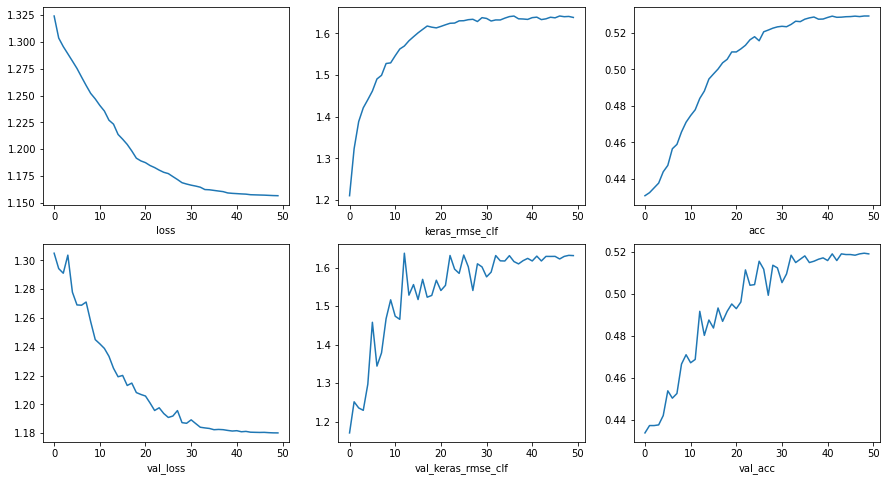

In [55]:
vis_metrics(history)

In [70]:
y_val.values[0]

0

In [101]:
def plot_pred(n, axis):
    sample = X_val[n]
    rgb = sample.transpose()[2:5]
    axis.imshow(rgb.transpose())
    axis.set_title(f"label: {y_val.values[n]+1}")
    sample = np.expand_dims(sample, axis=0)
    pred = np.argmax(model.predict(sample))
    axis.set_xlabel(f"Predicted: {pred}");
    
    
# randomly viz some of the preds and their rgb_imgs
def viz_preds():
    rand_n = np.random.randint(low=0, high=3144, size=25)
    fig, axis = plt.subplots(5, 5, figsize=(30, 25))
    for n, ax in zip(rand_n, axis.ravel()):
        plot_pred(n, ax)

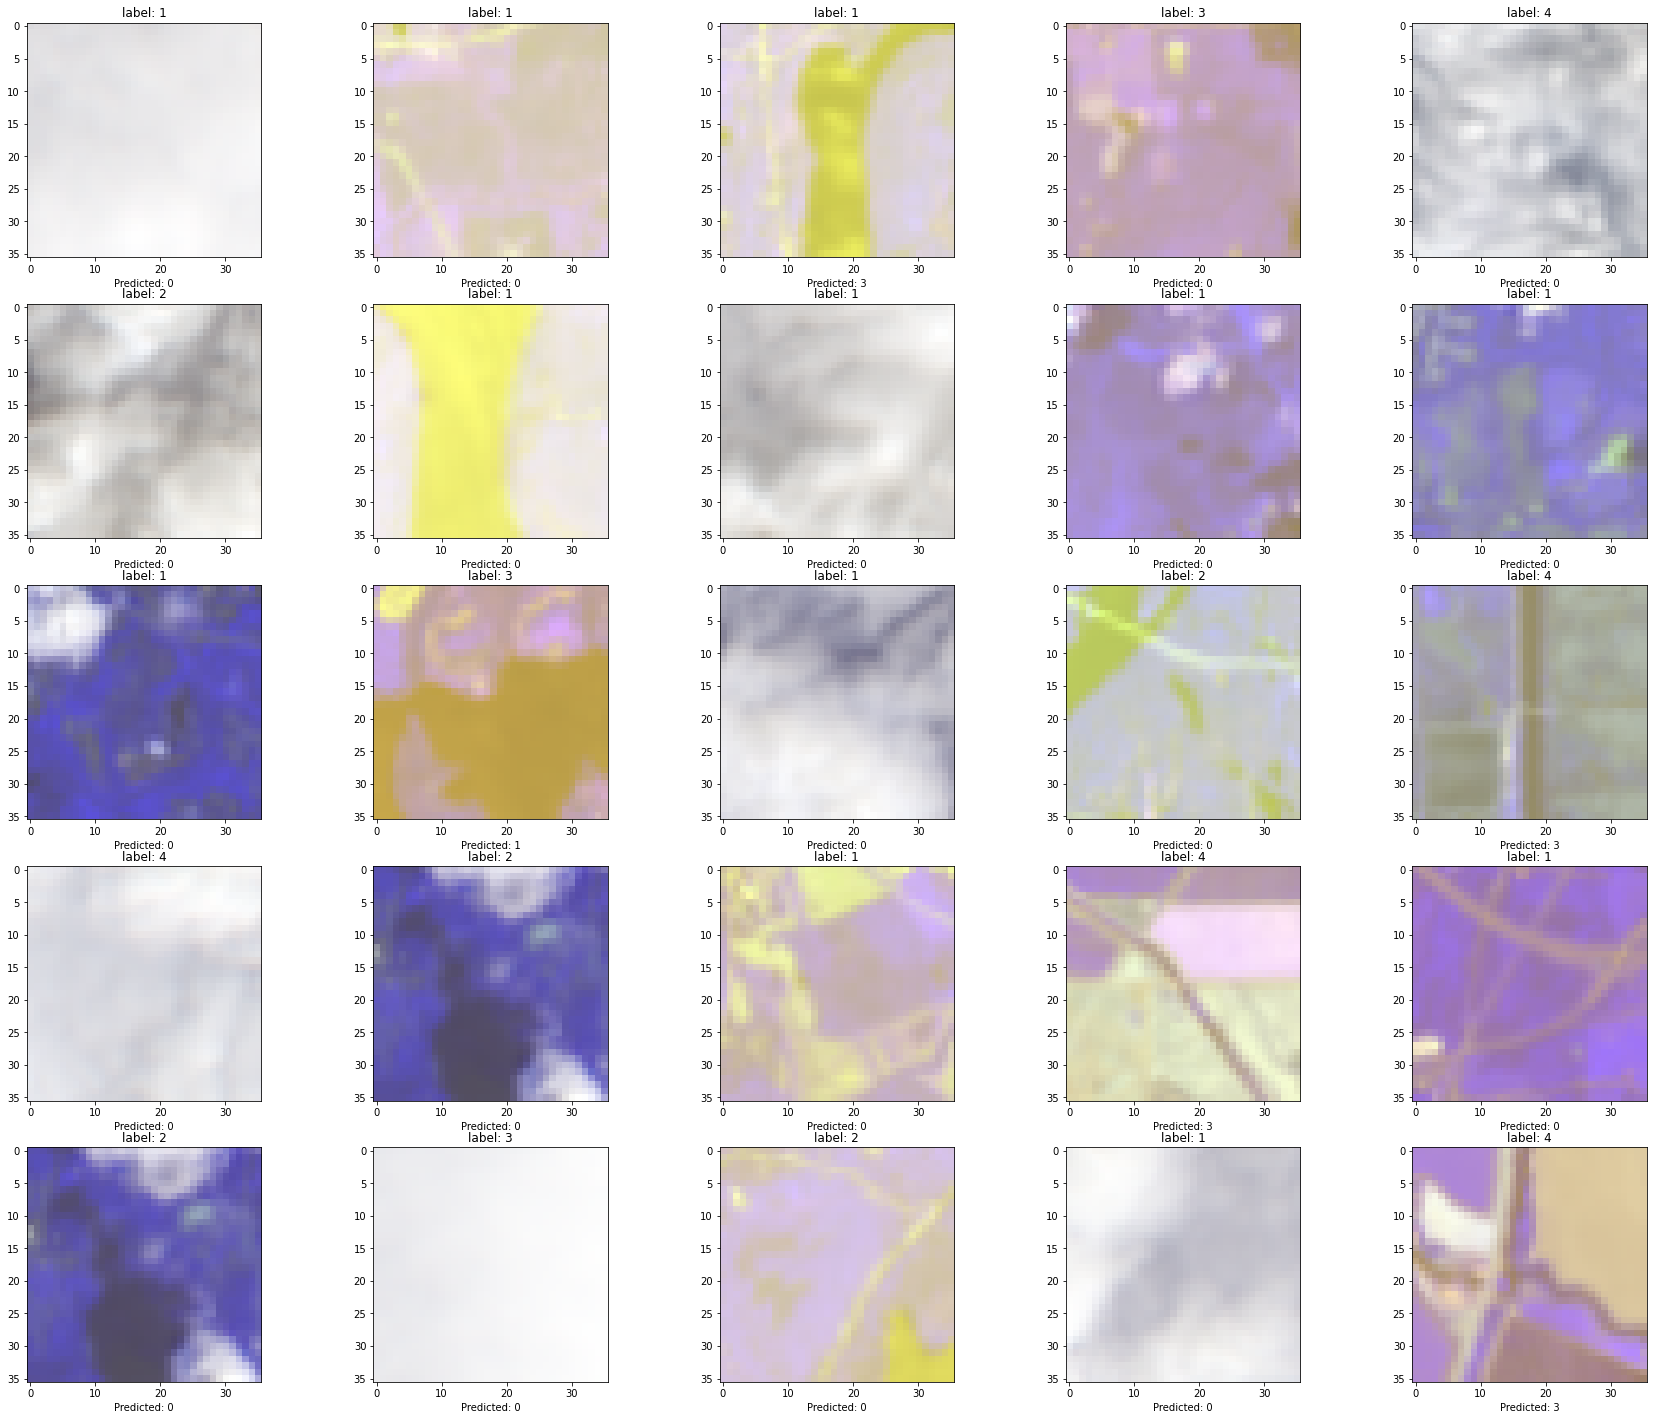

In [102]:
viz_preds()

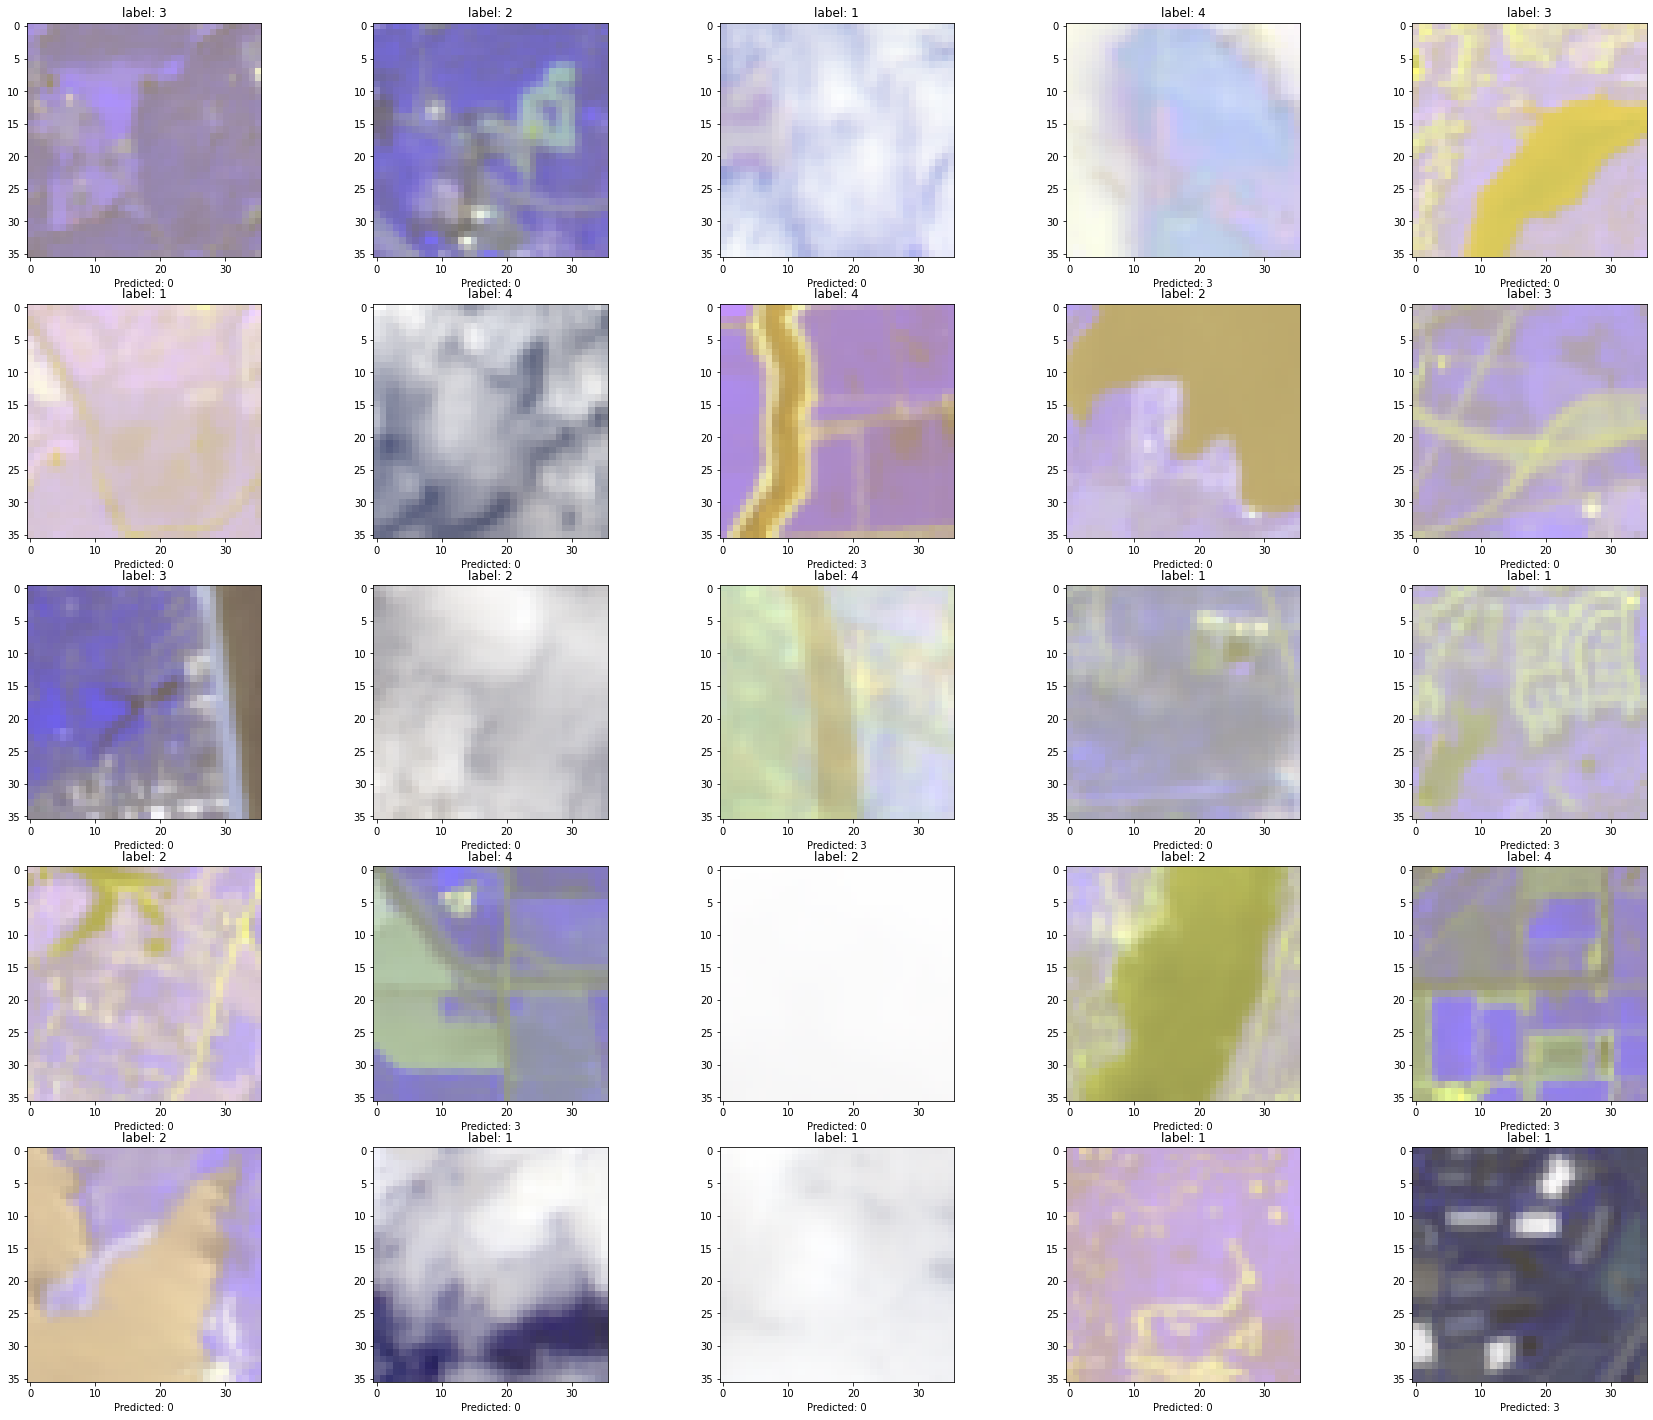

In [103]:
viz_preds()

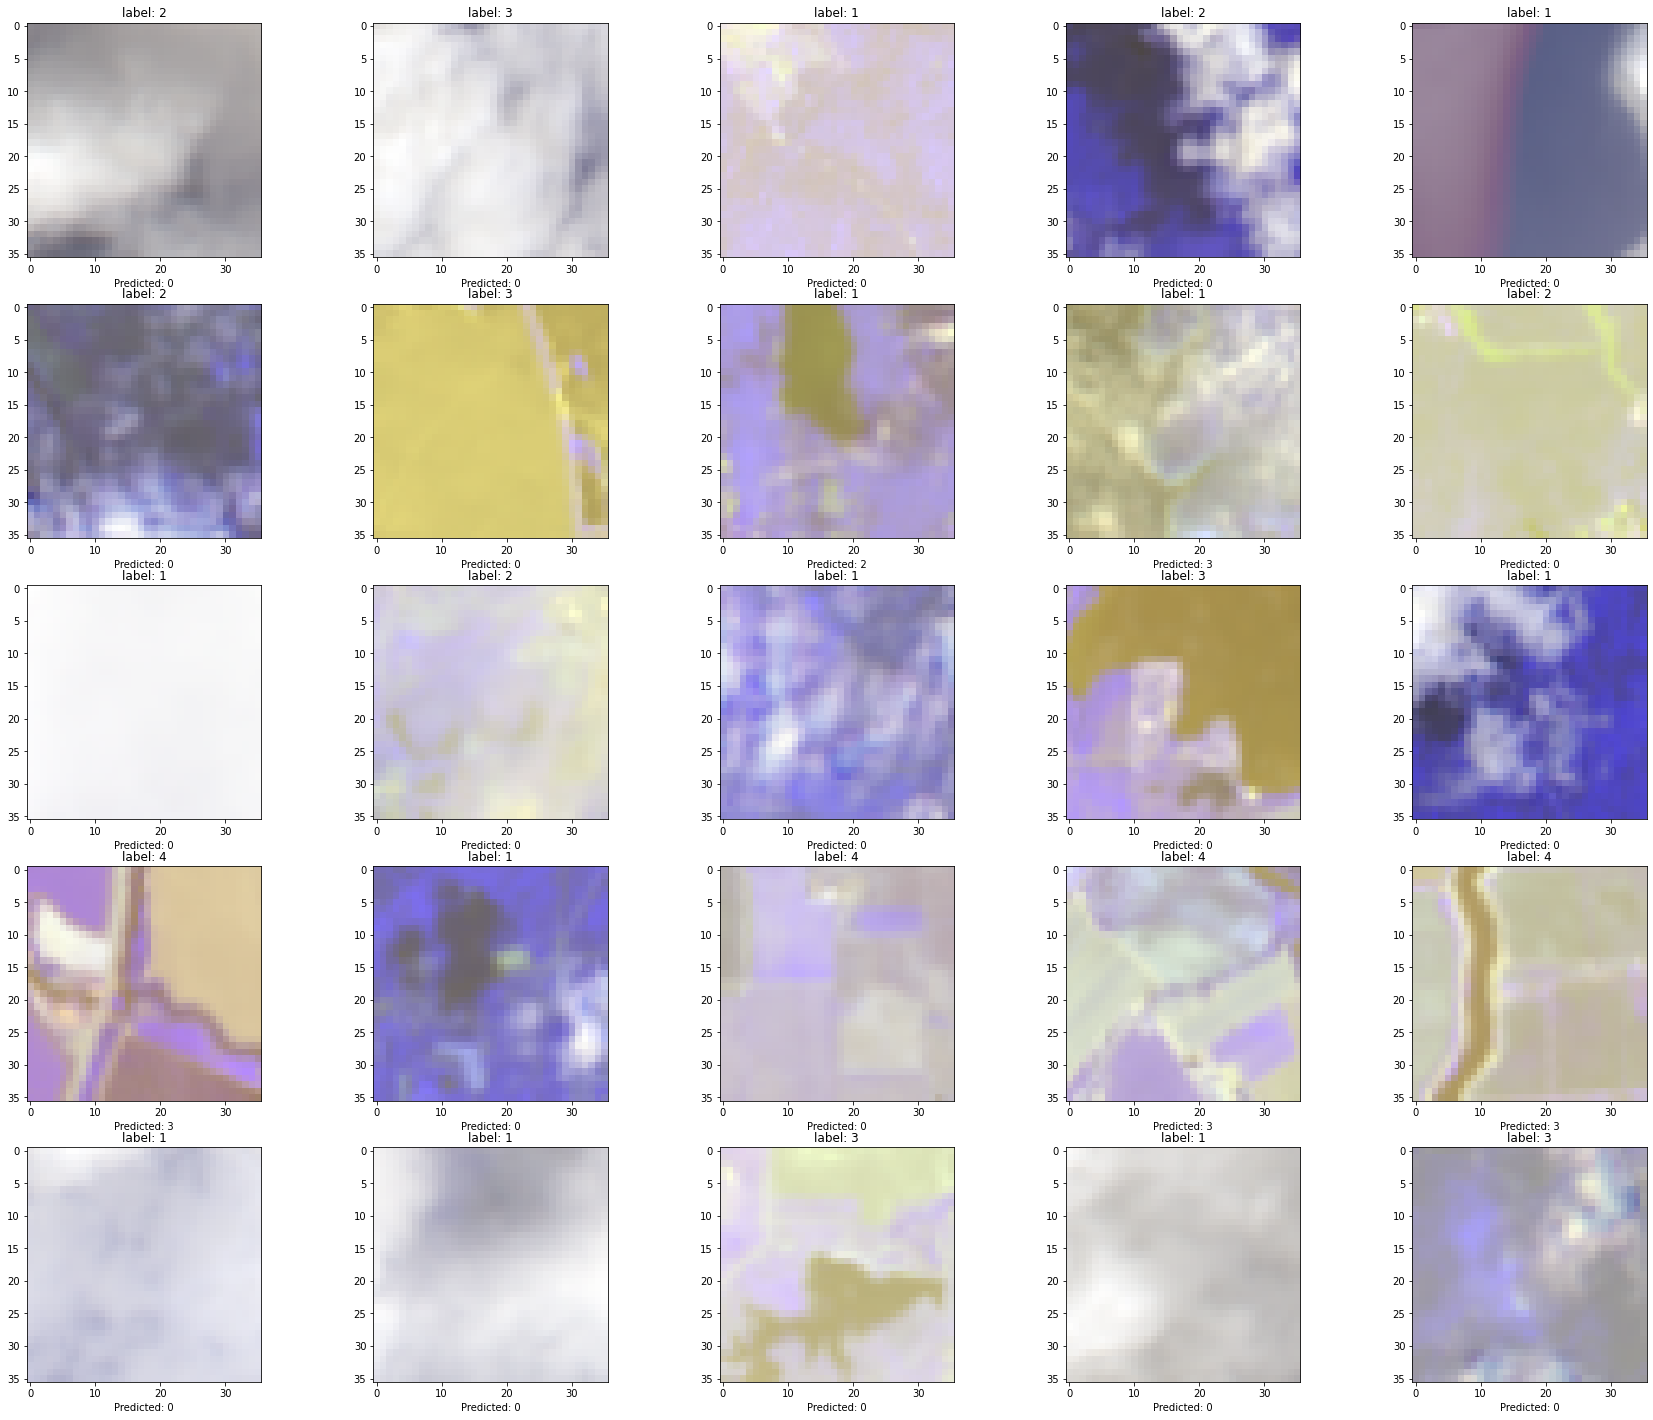

In [104]:
viz_preds()

In [ ]:
#  No wayy! even I can figure out what is what!!

In [ ]:
# model = models.load_model('/kaggle/working/d128_rmse_lndsat8_raw_v1-1673283452.h5', custom_objects={'comp_loss': comp_loss})
# preds = model.predict(X_val)
# int_preds = np.round(preds)
# mse(y_val, int_preds, squared=False)

# Save something..

In [56]:
# save model
if config.SAVE_MODEL:
    model.save(config.name + '.h5')
    print("Model saved as ",config.name + '.h5')

Model saved as  conv2d64_d128-1673608743.h5


# Make submission

In [57]:
model.summary()

Model: "conv2d64_d128-1673608743"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 36, 36, 5)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 64)        2944      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4735232   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 5)    

In [ ]:
# X_test.shape

In [ ]:
# # test_preds = np.round(model.predict(X_test)).ravel()
# test_preds = np.argmax(model.predict(X_test), axis=1)
# test_preds = test_preds + 1
# sub_format.severity = test_preds
# sub_format.severity = sub_format.severity.astype(int) 
# sub_format.severity.value_counts()

In [ ]:
# save_file_to = f'{config.name}_preds.csv'
# print(f'saving file to {save_file_to}')
# sub_format.to_csv(save_file_to, index=False) # expect @ 0.979 0.98

# So...

- Model is not learning at alll - just better than random guessing!
- What could be the reason???

> Such terrible data?  (most probbale)

> bad Normalization or what?

> Atleast it tried to learn? (40--> 50) acc

- OOM erros :(

* # ToDos:

- if terrible data 

> Download much wider bbox

> more informative bands (band processing/indexes)

> Try different satellite imgs

> Try same dataset with gbs and see if they peform any bettter or do they learn anything!

- Fix oom error
- Best way to normalize bands?
- Try with target as density.


**MOST PROBABLY THIS COMPETITION WINNER WILL BE THE ONE WHO HAS BETTER DATA HANDLING TECHNIQUES..**

> 